**Datawrangling using Python API of Spark - Part 2**

In this notebook I will be analyzing CSV data using Python API of spark. See the **table of contents** for the topics that are being covered. 

**Table of Contents**

- Reading data 
- User Defined Functions
- Explode a column of Type Array 
- Joining Table (Inner)
- Aggregation
- Visualization with Plotly
- Window Functions (Ranking)

The data is obtained from MovieLens can be found here https://grouplens.org/datasets/movielens/25m/

**The first part can be found here** https://github.com/rajatprasad1995/Pyspark-demo/blob/main/Data%20wrangling/Data%20wrangling.ipynb

Import findspark to run spark on local mode 

In [1]:
import findspark

In [2]:
findspark.init()

Import **SparkSession** from *Pyspark.sql* to create a Spark Session, I will also be enabling **hive support** to read and write tables to hive.

I am going to run this session locally on my machine and use all cores available.

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.enableHiveSupport().appName(
    "Movie lens data wrangling").master("local[*]").getOrCreate()

Now that we have the spark session up and running we can read the files, the files are in csv format (comma separated) where **comma are escaped in double quotes**. The files are encoded in **UTF-8**.

### Reading data 

In [5]:
ratings = spark.read.format("csv").option("delimiter", ",").option(
    "ESCAPE quote",
    '"').option("header",
                True).option("encoding",
                             "UTF-8").load("movielens/ml-25m/ratings.csv")

Let's take a look at the table

In [6]:
ratings.show(10)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
+------+-------+------+----------+
only showing top 10 rows



Importing **functions** module from pyspark.sql 

Importing **types** module from pyspark.sql 

In [7]:
from pyspark.sql import functions as f
from pyspark.sql import types as t

Let's take a look at **data types** of each column

In [8]:
ratings.dtypes

[('userId', 'string'),
 ('movieId', 'string'),
 ('rating', 'string'),
 ('timestamp', 'string')]

**timestamp** column is of type string and **rating** is of type string. They need to be *casted* in the desirable data type

In [9]:
ratings = ratings.withColumn(
    'timestamp',
    f.from_unixtime(ratings.timestamp.cast(dataType=t.LongType())))

ratings = ratings.withColumn('rating',
                             ratings.rating.cast(dataType=t.FloatType()))

Let's take a look at number of partitions **ratings** table have

In [10]:
ratings.rdd.getNumPartitions()

6

I will now be reading movies.csv which contains **information** of each movie

In [11]:
movies = spark.read.format("csv").option("delimiter", ",").option(
    "ESCAPE quote",
    '"').option("header",
                True).option("encoding",
                             "UTF-8").load("movielens/ml-25m/movies.csv")

Let's take a look at the table

In [12]:
movies.show(10)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
+-------+--------------------+--------------------+
only showing top 10 rows



I will save the table to cache, as I will perform some operations on it and caching will improve performance.

In [14]:
movies.persist()

DataFrame[movieId: string, title: string, genres: string]

Taking a look at datatypes of each column

In [15]:
movies.dtypes

[('movieId', 'string'), ('title', 'string'), ('genres', 'string')]

We can see that the column **genres** is of type string and contains all the genres a movie belongs to, seperated by "|" 

I am going to convert it to a **Array of type String** to make further analysis of the dataset easier

### User Defined Function

Now I will write a function in Python and then register it with spark, so that it can be used with the worker machines.
Spark will serialize the function on the driver and transfer it over the network to all executor processes.

In [16]:
def convert_to_list(genre_string):
    # create a list by splitting the string on "|"
    genre_list = genre_string.split("|")
    # remove all unwanted spaces on each element of the list
    return [i.strip() for i in genre_list]

Now the function is defined, let's **register** it with Spark, first I have to **import** the udf function from **pyspark.sql.functions** the module.

While registering we need to mention the expected data type of the output of the function, in this case it is an **Array**.

In [17]:
from pyspark.sql.functions import udf

In [18]:
convert_to_list_udf = udf(convert_to_list, t.ArrayType(t.StringType()))

Now the function **convert_to_list** is registered with spark and is called **convert_to_list_udf**


I will create a new column called **genres_list** that will contain the list of all genres a movie belongs to

In [19]:
movies = movies.withColumn("genres_list",
                           convert_to_list_udf("genres")).select(
                               "movieId", "title", "genres_list")

In [20]:
movies.show()

+-------+--------------------+--------------------+
|movieId|               title|         genres_list|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|[Adventure, Anima...|
|      2|      Jumanji (1995)|[Adventure, Child...|
|      3|Grumpier Old Men ...|   [Comedy, Romance]|
|      4|Waiting to Exhale...|[Comedy, Drama, R...|
|      5|Father of the Bri...|            [Comedy]|
|      6|         Heat (1995)|[Action, Crime, T...|
|      7|      Sabrina (1995)|   [Comedy, Romance]|
|      8| Tom and Huck (1995)|[Adventure, Child...|
|      9| Sudden Death (1995)|            [Action]|
|     10|    GoldenEye (1995)|[Action, Adventur...|
|     11|American Presiden...|[Comedy, Drama, R...|
|     12|Dracula: Dead and...|    [Comedy, Horror]|
|     13|        Balto (1995)|[Adventure, Anima...|
|     14|        Nixon (1995)|             [Drama]|
|     15|Cutthroat Island ...|[Action, Adventur...|
|     16|       Casino (1995)|      [Crime, Drama]|
|     17|Sen

In [21]:
movies.dtypes

[('movieId', 'string'), ('title', 'string'), ('genres_list', 'array<string>')]

### Explode

It would be nice to create a seperate row per genre for each movie that can help with further analysis of the dataset.

For that I would use **explode** function from the pyspark.sql.functions module 

In [22]:
from pyspark.sql.functions import explode

In [23]:
movies = movies.withColumn("genres_list_exploded",
                           explode(f.col("genres_list"))).drop("genres_list")

Let's take a look at the result

In [24]:
movies.show()

+-------+--------------------+--------------------+
|movieId|               title|genres_list_exploded|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|           Adventure|
|      1|    Toy Story (1995)|           Animation|
|      1|    Toy Story (1995)|            Children|
|      1|    Toy Story (1995)|              Comedy|
|      1|    Toy Story (1995)|             Fantasy|
|      2|      Jumanji (1995)|           Adventure|
|      2|      Jumanji (1995)|            Children|
|      2|      Jumanji (1995)|             Fantasy|
|      3|Grumpier Old Men ...|              Comedy|
|      3|Grumpier Old Men ...|             Romance|
|      4|Waiting to Exhale...|              Comedy|
|      4|Waiting to Exhale...|               Drama|
|      4|Waiting to Exhale...|             Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|              Action|
|      6|         Heat (1995)|               Crime|
|      6|   

### Join

I will be performing an **inner** join between ratings and movies tables by using the common column **"movieId"**. 

Later I will drop the **movieId** column of **movies** table.

But first I will repartition the table with column **movieId**


In [25]:
movies = movies.repartition("movieId")

In [26]:
joined_movies_ratings = movies.join(ratings,
                                    (movies.movieId == ratings.movieId),
                                    "inner").drop(movies["movieId"])

joined_movies_ratings.show()

+--------------------+--------------------+------+-------+------+-------------------+
|               title|genres_list_exploded|userId|movieId|rating|          timestamp|
+--------------------+--------------------+------+-------+------+-------------------+
| Pulp Fiction (1994)|            Thriller|     1|    296|   5.0|2006-05-17 17:34:04|
| Pulp Fiction (1994)|               Drama|     1|    296|   5.0|2006-05-17 17:34:04|
| Pulp Fiction (1994)|               Crime|     1|    296|   5.0|2006-05-17 17:34:04|
| Pulp Fiction (1994)|              Comedy|     1|    296|   5.0|2006-05-17 17:34:04|
|Three Colors: Red...|               Drama|     1|    306|   3.5|2006-05-17 14:26:57|
|Three Colors: Blu...|               Drama|     1|    307|   5.0|2006-05-17 14:27:08|
|  Underground (1995)|                 War|     1|    665|   5.0|2006-05-17 17:13:40|
|  Underground (1995)|               Drama|     1|    665|   5.0|2006-05-17 17:13:40|
|  Underground (1995)|              Comedy|     1|    

### Aggregation

Now I will calculate the total number of ratings for each genre and average rating for each genre.

But before doing that I will drop **movies** table from the **cache** and I will save the joined table to the cache. All this to boost performance.

In [27]:
movies.unpersist()

joined_movies_ratings.persist()

DataFrame[title: string, genres_list_exploded: string, userId: string, movieId: string, rating: float, timestamp: string]

I will aggregate by the column that contains the genre of a movie and **calculate** number of ratings per genre and **average** rating received by a genre

In [28]:
agg_movies_ratings = joined_movies_ratings.groupBy("genres_list_exploded").agg(
    f.count("rating").alias("total_ratings_received"),
    f.avg("rating").alias("average_rating_received"))

agg_movies_ratings.show()

+--------------------+----------------------+-----------------------+
|genres_list_exploded|total_ratings_received|average_rating_received|
+--------------------+----------------------+-----------------------+
|               Crime|               4190259|      3.685043693003225|
|             Romance|               4497291|     3.5427121571630567|
|            Thriller|               6763272|     3.5229643285084498|
|           Adventure|               5832424|      3.517444633654892|
|               Drama|              10962833|      3.677184674800756|
|                 War|               1267346|     3.7914657875591984|
|         Documentary|                322449|     3.7052805249822454|
|             Fantasy|               2831585|        3.5115889157486|
|             Mystery|               2010995|      3.670169244577933|
|             Musical|                964252|      3.554715987107105|
|           Animation|               1630987|      3.614946348438093|
|           Film-Noi

### Visualization by using Pandas and Plotly

Saving it as Pandas Dataframe to be able to visualize

In [29]:
agg_movies_ratings_pandas = agg_movies_ratings.toPandas()

In [30]:
agg_movies_ratings_pandas.head()

,genres_list_exploded,total_ratings_received,average_rating_received
0,Crime,4190259,3.685044
1,Romance,4497291,3.542712
2,Thriller,6763272,3.522964
3,Adventure,5832424,3.517445
4,Drama,10962833,3.677185


**Importing Plotly express and pandas**

In [31]:
import plotly.express as px
import pandas as pd

#### Horizontal Bar plot

Plotting a horizontal bar chart depicting **total number of ratings** received by each genre

I will be using **px.bar** function to generate the plot

In [32]:
fig = px.bar(agg_movies_ratings_pandas.sort_values("total_ratings_received"),
             x="total_ratings_received",
             y="genres_list_exploded",
             labels={
                 "total_ratings_received": "Total Ratings",
                 "genres_list_exploded": "genre"
             },
             orientation='h',
             title='Total ratings per Genre')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.write_image("ratings_genre_total.jpeg")
#fig.show()

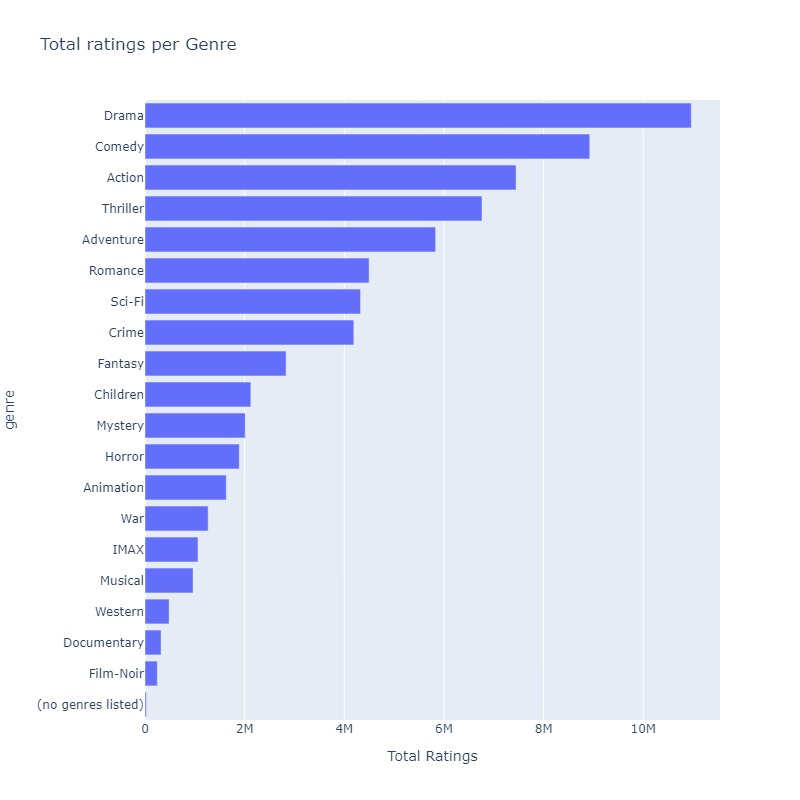

The genre **Drama** received the most ratings followed by **Comedy**

Plotting a horizontal bar chart depicting **average ratings** received by each genre

In [33]:
fig = px.bar(agg_movies_ratings_pandas.sort_values("average_rating_received"),
             x="average_rating_received",
             y="genres_list_exploded",
             labels={
                 "average_rating_received": "Average Rating",
                 "genres_list_exploded": "genre"
             },
             orientation='h',
             title='Average rating per Genre')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
# setting the range of x axis to emphasize the difference between different genres
fig.update_layout(xaxis=dict(range=[2.5, 4.5]))
fig.write_image("ratings_genre_average.jpeg")
#fig.show()

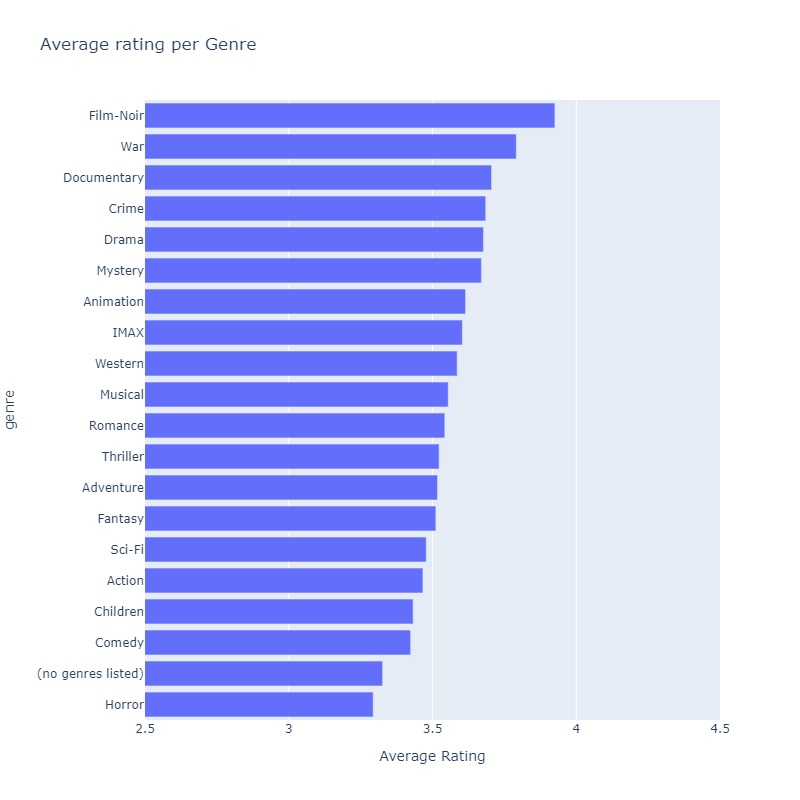

Horror received the lowest rating with 3.29

hard to impress Horror movies fans? 

#### Box plot

I am going to analyze the distribution of ratings **(especially identifying outliers)** received by horror movies by using box plot

In [34]:
horror = joined_movies_ratings.where(
    f.col("genres_list_exploded") == "Horror").toPandas()

In [35]:
horror.head()

,title,genres_list_exploded,userId,movieId,rating,timestamp
0,Hour of the Wolf (Vargtimmen) (1968),Horror,1,8405,3.5,2006-05-17 17:01:35
1,"Mummy, The (1999)",Horror,2,2617,4.0,2006-03-03 20:54:34
2,"Sixth Sense, The (1999)",Horror,2,2762,4.0,2006-03-03 20:57:03
3,"Others, The (2001)",Horror,2,4720,4.0,2006-03-03 21:14:10
4,"Silence of the Lambs, The (1991)",Horror,3,593,4.0,2015-08-13 15:23:23


I will be using the **px.box** function to generate the box plot

In [36]:
fig = px.box(horror,
             x="genres_list_exploded",
             y="rating",
             labels={
                 "rating": "Rating",
                 "genres_list_exploded": "genre"
             },
             notched=True)
fig.update_layout(
    autosize=False,
    width=800,
    height=400,
)
fig.write_image("box_plot_horror.jpeg")
#fig.show()

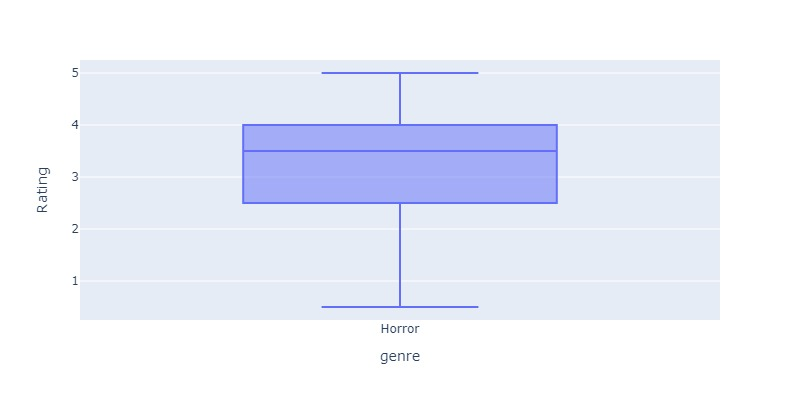

50% of the ratings received by horror movies are between **2.5 and 4**

#### histogram

Another way of analyzing the distribution of ratings is by using the histogram

In [37]:
fig = px.histogram(horror, x="rating")
fig.update_layout(
    autosize=False,
    width=1000,
    height=400,
)
fig.write_image("hist_plot_horror.jpeg")
#fig.show()

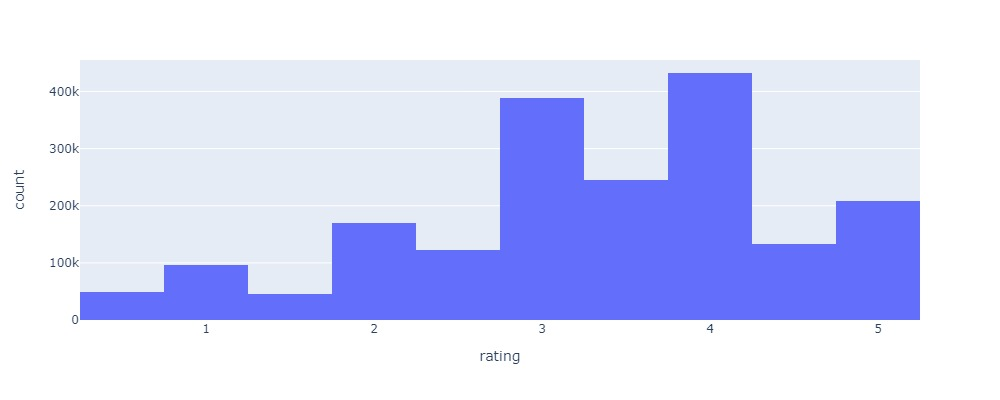

Most of the fans rated horror movies between 3 and 4. Few rated lower or higher

### Windows Functions (Ranking)

Let's find the Top **two most rated genres** for each and every year in the given data set?

For this I will be making use of **window functions**

*A window function calculates a return value for every input row of a table based on a group of rows, called a frame.*

I will be calculating the number of ratings a genre received in a given year, rank them and keep the top two genres.

I begin this process by extracting year from the timestamp column.

For that I will need to import **datetime** library

In [38]:
import datetime

Writing a function to extract year from the datetime column

In [39]:
def get_year(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year

registering **get_year** function as UDF

In [40]:
get_year_udf = udf(get_year, t.IntegerType())

Creating a new column called **year** 

In [41]:
joined_movies_ratings = joined_movies_ratings.withColumn(
    "year", get_year_udf(f.col("timestamp")))

Creating a window which would be partitioned by year and ordered by total votes received by a genre in a year

In [42]:
from pyspark.sql.window import Window

In [43]:
windowSpec = Window.partitionBy("year").orderBy(
    f.desc("total_ratings_received"))

**Grouping** the joined_movies_ratings dataframe to calculate **total number of ratings** received by a genre in a year

later calculating **rank** of each genre, such that the genre that gets the most ratings in a year would be ranked first, for this I am using **rank() function** from pyspark.sql.functions module over the window defined in the above cell.

Later I am filtering and keeping only those genre that obtained the first or the second rank.

In [44]:
most_rated_genre_year = joined_movies_ratings.groupBy(
    "year", "genres_list_exploded").agg(
        f.sum("rating").alias("total_ratings_received")).withColumn(
            "rank",
            f.rank().over(windowSpec)).where((f.col("rank") == 1)
                                             | (f.col("rank") == 2))

Showing **top two most rated** genres per year, ordered by year

In [45]:
most_rated_genre_year.orderBy("year", "rank").show(50)

+----+--------------------+----------------------+----+
|year|genres_list_exploded|total_ratings_received|rank|
+----+--------------------+----------------------+----+
|1995|            Thriller|                   8.0|   1|
|1995|              Comedy|                   6.0|   2|
|1995|               Crime|                   6.0|   2|
|1996|               Drama|             2280913.0|   1|
|1996|              Comedy|             1824731.0|   2|
|1997|               Drama|              986834.0|   1|
|1997|              Comedy|              797087.0|   2|
|1998|               Drama|              449902.0|   1|
|1998|              Comedy|              331246.0|   2|
|1999|               Drama|             1867681.0|   1|
|1999|              Comedy|             1456820.0|   2|
|2000|               Drama|             2912848.0|   1|
|2000|              Comedy|             2333664.0|   2|
|2001|               Drama|             1711481.0|   1|
|2001|              Comedy|             1435035.

**Drama** received the most ratings every single year followed by sometimes **comedy** and sometimes **action** 

In [46]:
spark.stop()

Stopping the spark session